In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
IMAGE_SIZE = 256
BATCH_SIZE = 32

CHANNEL = 3
EPOCH = 30
n_classes = 7

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
            "../PlantVillage",
            shuffle = True,
            image_size = (IMAGE_SIZE, IMAGE_SIZE),
            batch_size = BATCH_SIZE 
           )

Found 4438 files belonging to 7 classes.


In [4]:
class_names = dataset.class_names
class_names

['Apple__Black__Rot',
 'Apple__Healthy',
 'Apple__Scab',
 'Cedar__Apple__Rust',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy']

In [5]:
len(dataset)

139

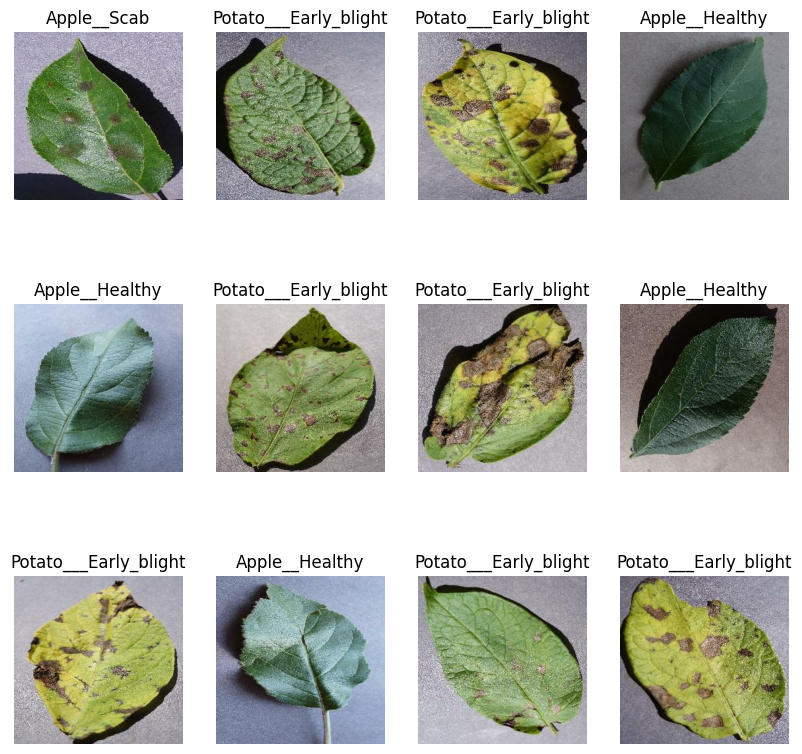

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [7]:
# 80% => Training
# 20% => 10% validation, 10% testing

In [8]:
train_size = 0.8
len(dataset) * train_size

111.2

In [9]:
train_ds = dataset.take(54) #raa[:54]
len(train_ds)

54

In [10]:
test_ds = dataset.skip(54)
len(test_ds)

85

In [11]:
val_size = 0.1
len(dataset) * val_size

13.9

In [12]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [13]:
test_ds = test_ds.skip(6)
len(test_ds)

79

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
        ds_size = len(ds)

        if shuffle:
            ds = ds.shuffle(shuffle_size, seed=12)
    
        train_size = int(train_split * ds_size)
        val_size = int(val_split * ds_size)

        train_ds = ds.take(train_size)
        val_ds = ds.skip(train_size).take(val_size)
        test_ds = ds.skip(train_size).skip(val_size)
    
        return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

111

In [17]:
len(val_ds)

13

In [18]:
len(test_ds)

15

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [20]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [21]:
# Data Augmentation -> If image is flip/rotate
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizonatal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [22]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNEL)

base_model = VGG16(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNEL),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(n_classes, activation='softmax')
])

In [23]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 8, 8, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [24]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [25]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    "../Store-Model/vgg16_model.keras",
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

history = model.fit(
    train_ds,
    epochs=EPOCH,
    validation_data=val_ds,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

Epoch 1/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.5752 - loss: 1.1959 
Epoch 1: val_accuracy improved from -inf to 0.87981, saving model to ../Store-Model/vgg16_model.keras
111/111 ━━━━━━━━━━━━━━━━━━━━ 2592s 23s/step - accuracy: 0.5764 - loss: 1.1927 - val_accuracy: 0.8798 - val_loss: 0.3865
Epoch 2/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8620 - loss: 0.4509
Epoch 2: val_accuracy improved from 0.87981 to 0.92548, saving model to ../Store-Model/vgg16_model.keras
111/111 ━━━━━━━━━━━━━━━━━━━━ 443s 4s/step - accuracy: 0.8621 - loss: 0.4504 - val_accuracy: 0.9255 - val_loss: 0.2321
Epoch 3/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8974 - loss: 0.3092
Epoch 3: val_accuracy improved from 0.92548 to 0.93750, saving model to ../Store-Model/vgg16_model.keras
111/111 ━━━━━━━━━━━━━━━━━━━━ 447s 4s/step - accuracy: 0.8975 - loss: 0.3092 - val_accuracy: 0.9375 - val_loss: 0.2068
Epoch 4/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9147 - los

In [26]:
scores = model.evaluate(test_ds)

15/15 ━━━━━━━━━━━━━━━━━━━━ 156s 10s/step - accuracy: 0.9872 - loss: 0.0367


In [27]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Get true & predicted labels
y_true = np.concatenate([y for x, y in val_ds], axis=0)
y_pred = model.predict(val_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

13/13 ━━━━━━━━━━━━━━━━━━━━ 129s 10s/step


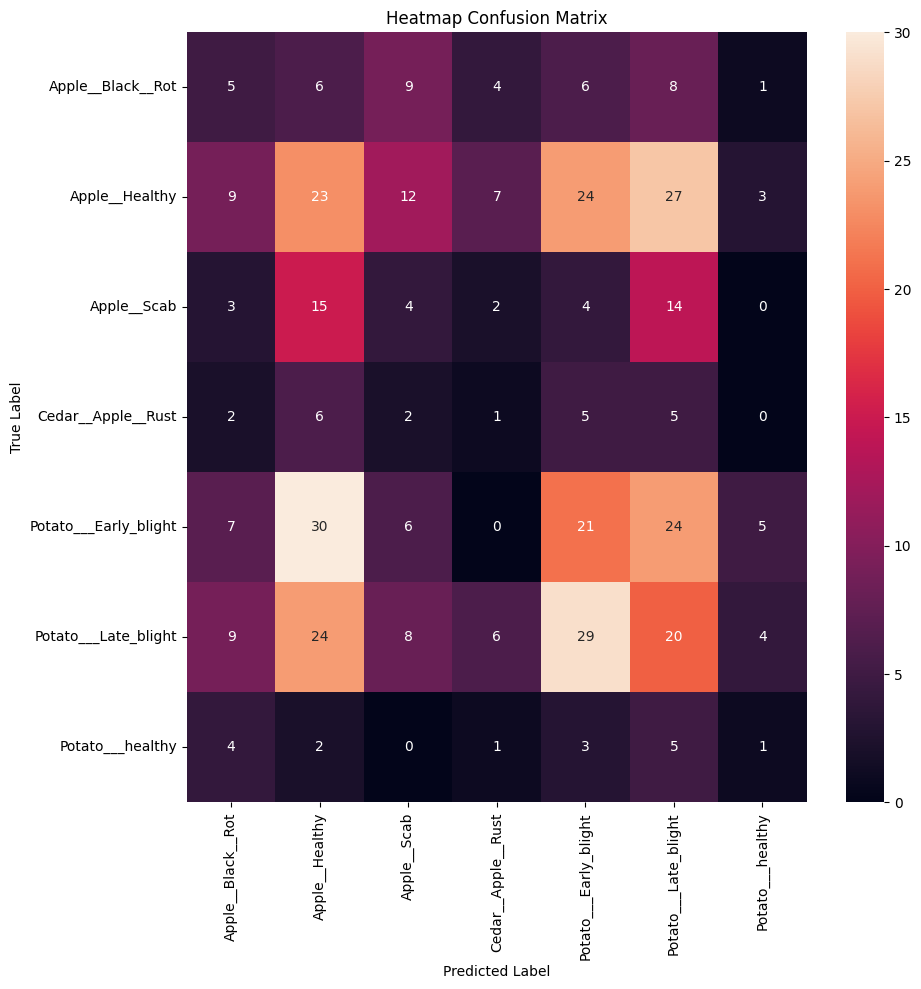

In [28]:
# Plot Heatmap Confusion Matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Heatmap Confusion Matrix')
plt.show()

In [29]:
scores

[0.03809056431055069, 0.987500011920929]

In [30]:
history

In [31]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 111}

In [32]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

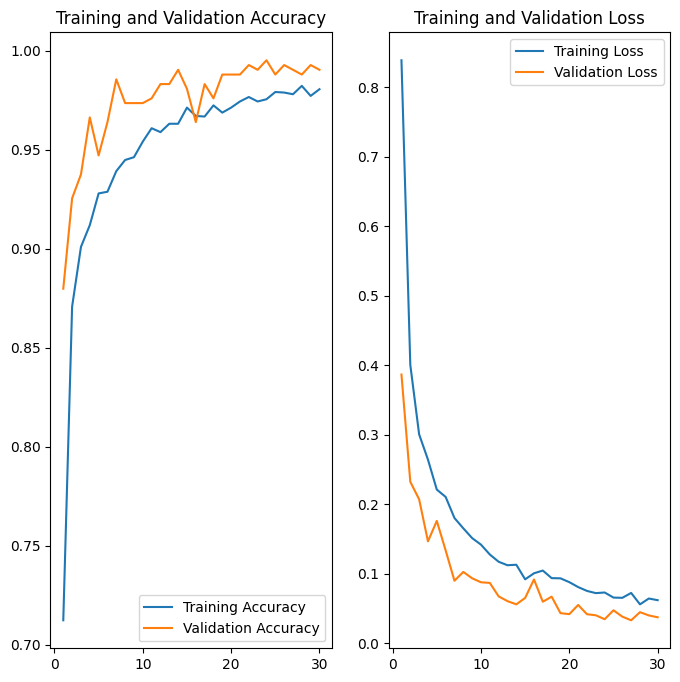

In [34]:
epochs = range(1, len(acc) + 1) 

plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

First image to predict


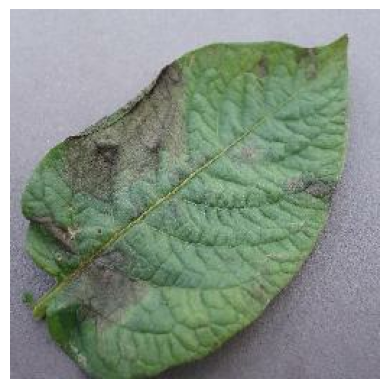

Actual Label :  Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
Predicted Label :  Potato___Late_blight


In [35]:
import numpy as np

# Take one batch from the test dataset
for image_batch, label_batch in test_ds.take(1):
    # Get the first image and label in the batch
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()

    # Display the image
    print("First image to predict")
    plt.imshow(first_image)
    plt.axis('off')  # hides axis
    plt.show()

    # Print the actual label
    print("Actual Label : ", class_names[first_label])
    
    # Predict the label for the entire batch
    batch_prediction = model.predict(image_batch)
    
    # Get the predicted class of the first image
    predicted_class = np.argmax(batch_prediction[0])
    print("Predicted Label : ", class_names[predicted_class])

In [36]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img.numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array, verbose=0)
    
    predicted_index = np.argmax(predictions[0])
    predicted_class = class_names[predicted_index]
    
    confidence = round(100 * np.max(predictions[0]), 2)
    
    return predicted_class, confidence

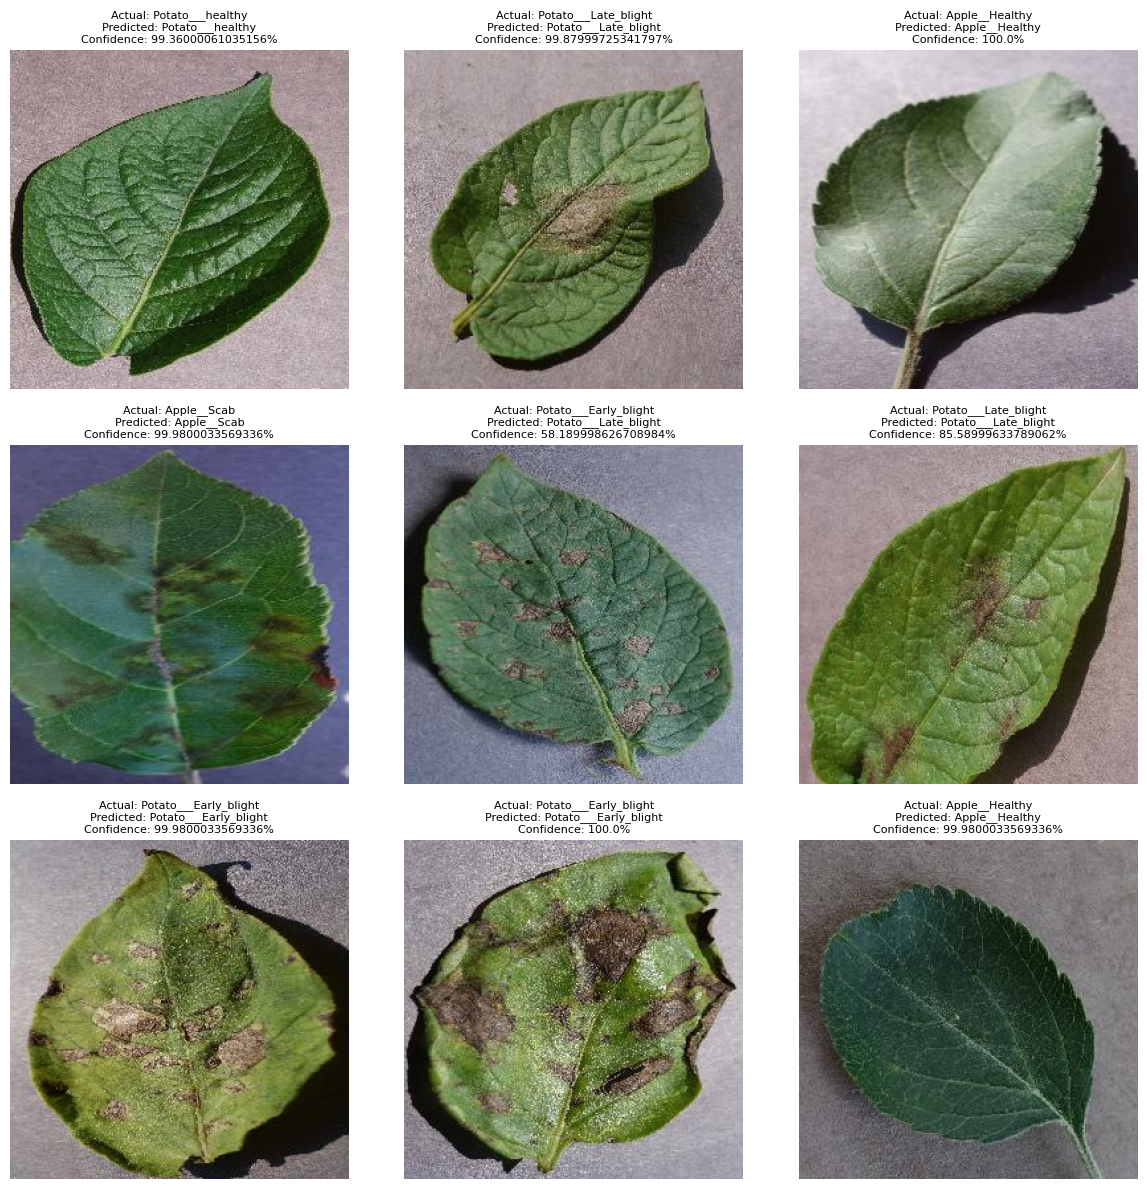

In [37]:
plt.figure(figsize=(12, 12))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[labels[i].numpy()]

        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%", fontsize=8)
        plt.axis("off")
        
plt.tight_layout()
plt.show()